In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from ripser import ripser
import persim
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from scipy.sparse import load_npz
import gudhi as gd
from igraph import Graph
from IPython.display import SVG, display
import matplotlib.pyplot as plt

In [12]:
ppi_df = pd.read_table("../../data/Gavin_PPI_Network.txt", header=0)
ppi_df.columns = ["ProteinA", "ProteinB", "SemSim"]
ppi_df.head()

,ProteinA,ProteinB,SemSim
0,YAL001C,YBR123C,0.983749
1,YAL001C,YDR362C,0.983363
2,YAL001C,YGR047C,0.952126
3,YAL001C,YOR110W,0.990000
4,YAL001C,YPL007C,0.948626


In [13]:
complexes_list = []
with open("../../data/Gavin_Original_Communities.txt") as complexes:
  for line in complexes:
    line = line.strip()
    temp_list = list(line.split("\t"))
    complexes_list.append(temp_list)

print(complexes_list)

[['YKL003C YBR251W YGL129C YBL090W YBR122C YCR003W YDR041W YNL005C YDR405W YMR158W YKL138C YML025C YPL118W YOR150W YPL183W-A YDR347W YKL155C YGR076C YDR116C YCR046C Q0140 YBL038W YJR113C YFR049W YBR146W YDL045W-A YNR022C YMR193W YJL063C YKL167C YPR100W YIL093C YHR075C YKL142W YDL202W YEL050C YKR085C YNL185C YGL068W YBR282W YNL284C YPL173W YLR439W YBR268W YDR115W YDR462W YER050C YJL096W YNL306W YCR071C YDR237W YGR165W YDR337W YMR225C YGR084C YHR147C YDR175C YGR220C YMR024W YHL004W YNR037C YPR166C YMR188C YKL170W YGR215W YMR286W YKR006C YNL252C YNL137C YJR101W YPL013C YNL177C YLR312W-A YOR158W YML009C YDR322W'], ['YHR021C YGL123W YCR031C YJL136C YDR025W YDL061C YBR189W YPL081W YLR333C YKR057W YLR441C YER102W YER131W YML024W YLR367W YLR388W YHL015W YBR048W YLR264W YKL156W YDR447C YLR048W YJR145C YGR118W YJL191W YGL189C YGR214W YPL090C YMR116C YNL302C YNL178W YOR293W YMR143W YNL096C YDR064W YER074W YOL040C YMR230W YLR287C-A YML063W YDL083C YPR132W YBL072C YOR182C YJR123W YOR369C YJL190C YI

In [14]:
protein_net = nx.from_pandas_edgelist(
    ppi_df,
    source='ProteinA',
    target='ProteinB',
    edge_attr='SemSim'
)

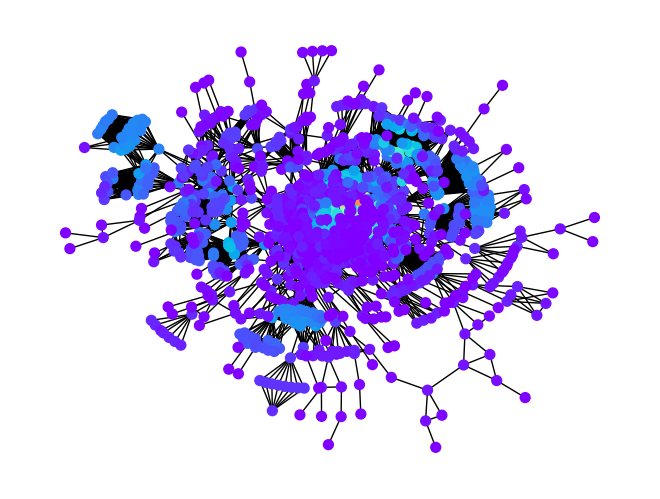

In [16]:
scaled_degree = [d[1]*50 for d in nx.degree(protein_net)]
nx.draw_kamada_kawai(protein_net,
        # Weights Based on Column
        #width=list(nx.get_edge_attributes(protein_net, 'SemSim').values()),
        # Node size based on degree
        node_size=50,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=False)

In [17]:
ppi_proteins = np.unique(ppi_df[['ProteinA', 'ProteinB']])

In [18]:
## Let's store the proteins in an indexed dictionary so we could track them back when building the simplex tree
proteins_dict = {protein: idx for idx, protein in enumerate(ppi_proteins)}

In [19]:
# Given protein-protein interaction network we can start by creating a simplex tree that includes all 0-simplices (nodes)

# Construct a simplex tree from the network
simplex_tree = gd.SimplexTree()

for edge in protein_net.edges(data=True):
    node1, node2, weight = edge
    ## Get protein index from dict to map it back and feed it into the simplex tree
    node1_idx = proteins_dict[node1]
    node2_idx = proteins_dict[node2]
    simplex_tree.insert([node1_idx, node2_idx], filtration=weight['SemSim'])


In [29]:
# Compute persistence diagrams
## NOTE: min_persistence is set to -1 to view all the simplex values (Include all 0-simplices)

persistence = simplex_tree.persistence(min_persistence=0, persistence_dim_max=True)

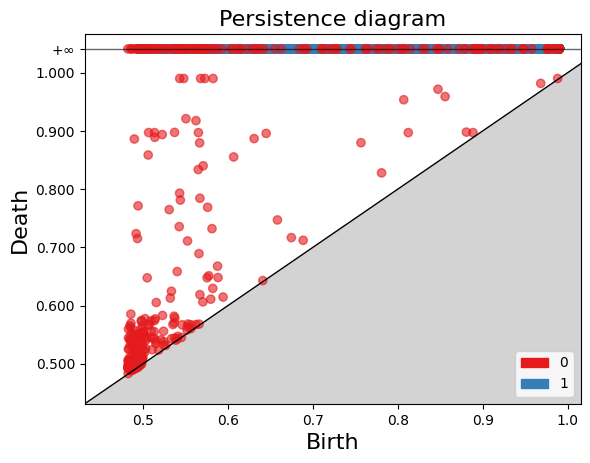

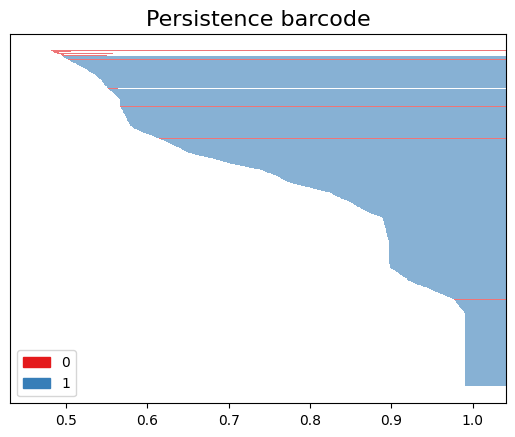

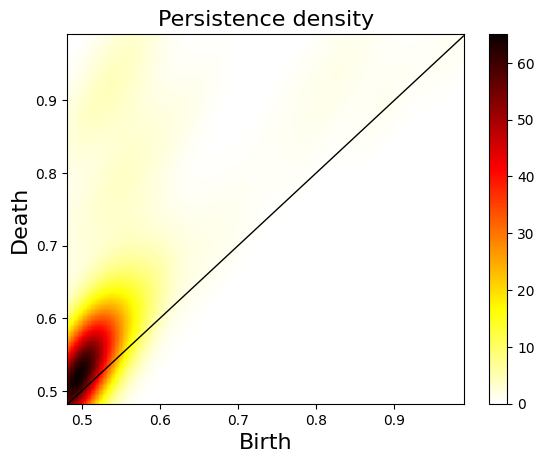

In [32]:
# Generate persistence diagrams
diagrams = gd.plot_persistence_diagram(persistence, max_intervals=0)
barcode = gd.plot_persistence_barcode(persistence, max_intervals=0)
density = gd.plot_persistence_density(persistence)